In [2]:
import os; import pathlib; from pathlib import Path; import numpy as np  ; import flopy    ; import matplotlib.pyplot as plt  ; import flopy.utils.binaryfile as bf
import pandas as pd; current_directory = os.getcwd();  print(current_directory)
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'  # ;  exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
Da_path = Path(r"E:\\15_REPOS\\00_BETAMI\\52_MT3D_El_Kadi\\ex_RES") ; Da_path.mkdir(exist_ok=True)
Db_path = Path(r"E:\\15_REPOS\\00_BETAMI\\52_MT3D_El_Kadi\\ex_RES\\19") ; Db_path.mkdir(exist_ok=True) ; output_folder = Db_path; ws = Db_path

E:\15_REPOS\00_BETAMI\52_MT3D_El_Kadi


In [2]:
Lx = 1000; Ly = 1000; ztop = 10; zbot = -50        ; nlay = 1; nrow = 10; ncol = 10      
delr = Lx / ncol            ; delc = Ly / nrow     ; delv = (ztop - zbot) / nlay     ; stageleft = 10        ; stageright = 0
botm = np.linspace(ztop, zbot, nlay + 1)           ; hk = 1; vka = 1                 ; sy = 0.1; ss = 1.e-4  ; laytyp = 1

ibound =       np.ones((nlay, nrow, ncol), dtype=np.int32)                        
strt   = 10. * np.ones((nlay, nrow, ncol), dtype=np.float32) 

nper = 3  ; perlen = [1, 100, 100]  ; nstp = [1, 100, 100]                           ; steady = [True, False, False]                   

In [3]:
modelname = 'transient'
mf  = flopy.modflow.Modflow(modelname, exe_name = exe_name_mf, model_ws = ws)  
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,top=ztop, botm=botm[1:],nper=nper, perlen=perlen, nstp=nstp, steady=steady)
bas = flopy.modflow.ModflowBas(mf, ibound = ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53)
pcg = flopy.modflow.ModflowPcg(mf)

bound_sp1 = []  
for il in range(nlay):
    condleft = hk * (stageleft - zbot) * delc                ; condright = hk * (stageright - zbot) * delc
    for ir in range(nrow):
        bound_sp1.append([il, ir, 0, stageleft, condleft])   ; bound_sp1.append([il, ir, ncol - 1, stageright, condright])
condleft = hk * (stageleft - zbot) * delc                    ; condright = hk * (stageright - zbot) * delc
bound_sp2 = []  
for il in range(nlay):
    for ir in range(nrow):
        bound_sp2.append([il, ir, 0, stageleft, condleft])   ; bound_sp2.append([il, ir, ncol - 1, stageright, condright])
spd = {0: bound_sp1, 1: bound_sp2}

ghb=flopy.modflow.ModflowGhb(mf, stress_period_data=spd);print('+',len(bound_sp1),'GHBs stress.P1.') ; print('+',len(bound_sp2),'GHBs stress.P2(3?).')

pumping_rate = -300.
wel_sp1 = [[0, nrow/2 - 1, ncol / 2 - 1, 0  ]]                 
wel_sp2 = [[0, nrow/2 - 1, ncol / 2 - 1, 0  ]]
wel_sp3 = [[0, nrow/2 - 1, ncol / 2 - 1, pumping_rate]]        
wel_spd = {0: wel_sp1, 1: wel_sp2, 2: wel_sp3}  ; 
wel = flopy.modflow.ModflowWel(mf, stress_period_data = wel_spd)

oc_spd = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
oc = flopy.modflow.ModflowOc(mf, stress_period_data = oc_spd                          , compact=True)      ; mf.write_input()

success, mfoutput = mf.run_model( silent = False, pause = False, report = True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

+ 20 GHBs stress.P1.
+ 20 GHBs stress.P2(3?).
FloPy is using the following executable to run the model: ..\..\..\bin\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.6.01 3/4/2009, with FMP2              

 Using NAME file: transient.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/03/17 11:11:34

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stre

In [4]:
hds = bf.      HeadFile(Path(ws) / f"{modelname}.hds")    ; times = hds.get_times() ;  head = hds.get_data(totim=times[-1])   ; headobj = hds
cbb = bf.CellBudgetFile(Path(ws) / f"{modelname}.cbc")    ; levels = np.linspace(0, 10, 11)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
wpt = ((float(ncol/2)-0.5)*delr, (float(nrow/2-1)+0.5)*delc) ; wpt = (450., 550.)  ; print('Levels: ',levels)  ; print('Extent: ', extent)

Levels:  [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
Extent:  (50.0, 950.0, 50.0, 950.0)


In [32]:
print(heads.shape)   # linespace ?

(1, 10, 10)


*****Processing time:  1.0
Head statistics
  min:  0.012193865
  max:  9.989839
  std:  3.1816995


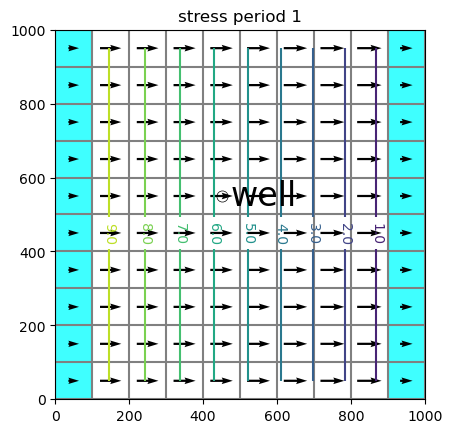

*****Processing time:  101.0
Head statistics
  min:  0.012193777
  max:  9.989838
  std:  3.1816993


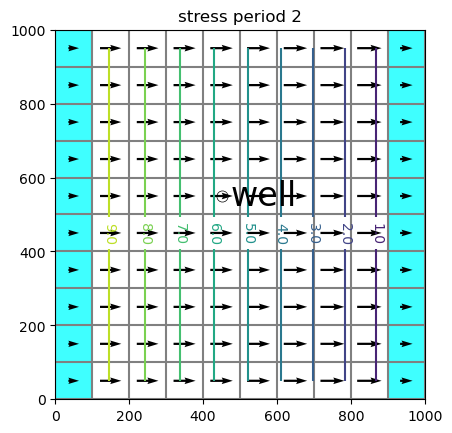

*****Processing time:  201.0
Head statistics
  min:  0.0109258015
  max:  9.989476
  std:  3.1701422


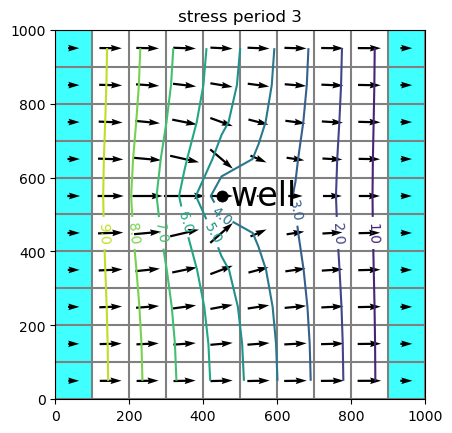

In [5]:
mytimes = [1.0, 101.0, 201.0]
for iplot, time in enumerate(mytimes):
    print('*****Processing time: ', time)                        ;     head = headobj.get_data(totim=time)
    print('Head statistics')   ; print('  min: ', head.min())    ;     print('  max: ', head.max())            ; print('  std: ', head.std())
    frf = cbb.get_data(text='FLOW RIGHT FACE', totim=time)[0]    ;     fff = cbb.get_data(text='FLOW FRONT FACE', totim=time)[0]
    f = plt.figure()  ; plt.subplot(1, 1, 1, aspect='equal')     ;     plt.title('stress period ' + str(iplot + 1))
    
    modelmap = flopy.plot.PlotMapView(model=mf, layer=0) ; qm=modelmap.plot_ibound() ; lc=modelmap.plot_grid() ; qm=modelmap.plot_bc('GHB', alpha=0.5)
    cs=modelmap.contour_array(head, levels=levels)       ; plt.clabel(cs, inline=1, fontsize=10, fmt='%1.1f', zorder=11)
    
    qx,qy,qz=flopy.utils.postprocessing.get_specific_discharge   ((frf,fff, None), mf, head)    ; quiver = modelmap.plot_vector(qx, qy)

    mfc = 'None'
    if (iplot+1) == len(mytimes):
        mfc='black'
    plt.plot(wpt[0]    , wpt[1]   , lw=0  , marker='o', markersize=8, markeredgewidth=0.5, markeredgecolor='black', markerfacecolor=mfc, zorder=9)
    plt.text(wpt[0]+25 , wpt[1]-25, 'well', size=24   , zorder=12)        
    plt.savefig(ws / 'transient-{}.png'.format(iplot))  ; plt.show()

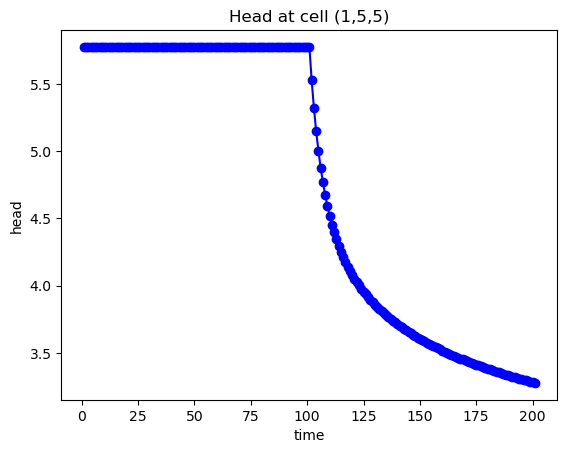

In [6]:
idx = (0, int(nrow/2) - 1, int(ncol/2) - 1)                                        ; ts = headobj.get_ts(idx)  ; plt.subplot(1, 1, 1)
ttl = 'Head at cell ({0},{1},{2})'.format(idx[0] + 1, idx[1] + 1, idx[2] + 1)      
plt.title(ttl) ; plt.xlabel('time') ; plt.ylabel('head') ; plt.plot(ts[:, 0], ts[:, 1], 'bo-') ; plt.show()
#  fig = plt.figure(figsize=(4, 2));  #  plt.savefig(ws / 'transient_head.png')

**& www.betami.com.br**






In [7]:
save = pd.DataFrame(bound_sp1)       ; save.to_csv (output_folder / "a_bound_sp1.csv")
save = pd.DataFrame(bound_sp2)       ; save.to_csv (output_folder / "b_bound_sp2.csv")
save = pd.DataFrame(spd)             ; save.to_csv (output_folder / "c_spd.csv")
save = pd.DataFrame(wel_sp3)         ; save.to_csv (output_folder / "d_wel_sp3.csv")
save = pd.DataFrame(wel_spd)         ; save.to_csv (output_folder / "e_wel_spd.csv") 
save = pd.DataFrame(oc_spd)          ; save.to_csv (output_folder / "f_oc_spd.csv") 
save = pd.DataFrame(times)           ; save.to_csv (output_folder / "g_times.csv") 

In [33]:
perlen = [1, 100, 100]  ; nstp = [1, 100, 100]      #    ; perlen2 = pd.DataFrame(perlen); perlen2.sum()   # idx
model_time = np.cumsum(perlen) ; model_time

array([  1, 101, 201])

In [39]:
head = headobj.get_data()

In [40]:
mytimes = [1.0, 101.0, 201.0]
#head = headobj.get_data(totim=  1)
#head = headobj.get_data(totim=101)
head = headobj.get_data(); print(head.shape)  # totim=201 (Last)

(1, 10, 10)


In [27]:
hds = bf.HeadFile(Path(ws)       / f"{modelname}.hds") 

In [8]:
nprs = 100   ; perlen = [1, 100, 100]   ;    # sum = 29 ... 0 to 29 (\100... till 102..)
timprs = np.linspace(0, np.sum(perlen), nprs, endpoint=True)    
# timprs   
print(timprs.shape)
save = pd.DataFrame(timprs); save.to_csv(output_folder /"h_timprs.csv")   # but no  (this is transport)

(100,)
